In [1]:
# import os
# from exp.exp_main import Exp_Main
# # args.output_attention = True

# exp = Exp_Main(args)

# model = exp.model

# setting = 'ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
# model.load_state_dict(torch.load(path))

In [6]:
import torch
print(torch.cuda.is_available())		 # 查看GPu设备是否可用
print(torch.cuda.device_count()) 		# 查看GPu设备数量
print(torch.cuda.get_device_name())   	# 查看当前GPu设备名称，默认设备id从0开始
print(torch.cuda.current_device())		# 查看当前GPu设备id


True
1
NVIDIA GeForce GTX 1050 Ti
0


In [7]:
torch.cuda.is_available() 
import torch
torch.cuda.set_device(0)

In [8]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main#exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021 
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')#模型id
parser.add_argument('--model', type=str, required=True, default='Autoformer',#选择模型
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')#数据类型
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')#数据文件夹路径
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')#具体文件
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')#不太懂 OT好像代表Output Target,要预测的单变量
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')#保存模型

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')#输入序列长度
parser.add_argument('--label_len', type=int, default=48, help='start token length')#这个label_len未完全搞懂
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#输出序列长度

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding不太能get到
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type2', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = ['Bitrate', 'Bitrate-RX']
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = '/home/endtheme/Downloads/cos40007/Design Project/'
args.data_path ='truck1-1.csv' 
args.model_id='truck1-2'
args.model = 'Autoformer'
args.data = '5G'
args.features = 'M'
args.seq_len = 120
args.label_len = 60
args.pred_len = 60
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 1
args.enc_in = 12
args.dec_in =12
args.c_out = 12
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 32 
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
print('Args in experiment:')
print(args)

Exp = Exp_Main




Args in experiment:
{'target': ['Bitrate', 'Bitrate-RX'], 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': '/home/endtheme/Downloads/cos40007/Design Project/', 'data_path': 'truck1-1.csv', 'model_id': 'truck1-2', 'model': 'Autoformer', 'data': '5G', 'features': 'M', 'seq_len': 120, 'label_len': 60, 'pred_len': 60, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'enc_in': 12, 'dec_in': 12, 'c_out': 12, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):#itr就是实验次数可不是epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)#setting是用来保存模型的名字用的，很细节
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)



Use GPU: cuda:0
1
>>>>>>>start training : truck1-2_Autoformer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>


AttributeError: module 'sklearn.preprocessing' has no attribute 'SomeScaler'

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example #模仿informer 的 colab example的custom_dataset与predict部分
import pandas as pd
exp.args.root_path = '/home/endtheme/Downloads/cos40007/Design Project/'
exp.args.data_path = 'truck1-1.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:
print(exp.args)

{'target': ['Bitrate', 'Bitrate-RX'], 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': '/home/endtheme/Downloads/cos40007/Design Project/', 'data_path': 'truck1-1.csv', 'model_id': 'truck1-2', 'model': 'Autoformer', 'data': '5G', 'features': 'M', 'seq_len': 120, 'label_len': 60, 'pred_len': 60, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'enc_in': 12, 'dec_in': 12, 'c_out': 12, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [ ]:

args.do_predict = True
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)#data_factory做好了pred里面的batch_size=1的情况，是autoformer在informer基础之上做的
    torch.cuda.empty_cache()
    # print(prediction.shape)

>>>>>>>predicting : truck1-2_Autoformer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
truck1-2_Autoformer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0
['datetime', 'longitude', 'latitude', 'svr1', 'svr2', 'svr3', 'svr4', 'Transfer size', 'Retransmissions', 'CWnd', 'Transfer size-RX', 'Bitrate-RX', 'Bitrate']
the target is:  ['Bitrate', 'Bitrate-RX']


ValueError: list.remove(x): x not in list

torch.Size([1, 12, 60])
torch.Size([60])


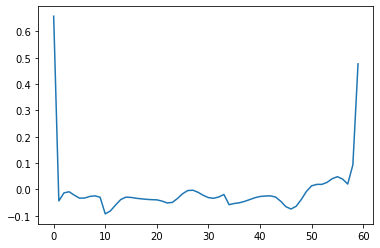

torch.Size([60])


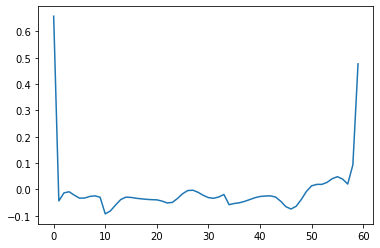

torch.Size([60])


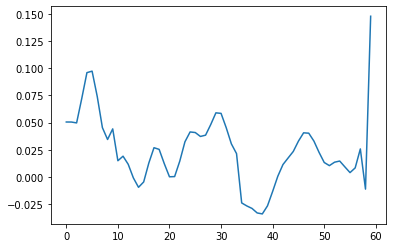

torch.Size([60])


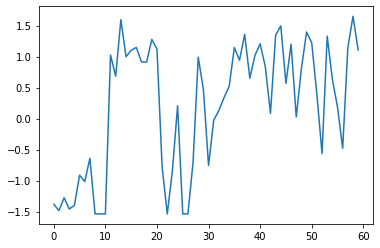

torch.Size([60])


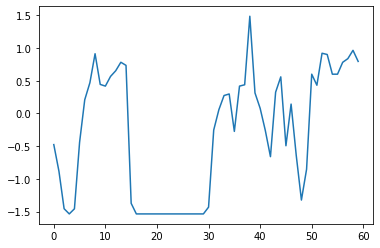

torch.Size([60])


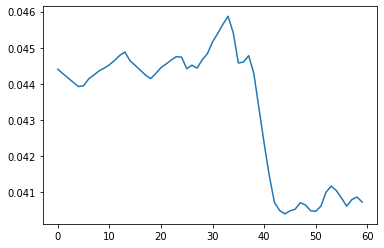

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
# data_pred = np.load('./results/ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
data_pred = np.load("/home/endtheme/Downloads/cos40007/Design Project/Autoformer/results/truck1_Transformer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/real_prediction.npy")
data_pred = torch.from_numpy(data_pred).permute(0,2,1)

plt.figure()
print(data_pred.shape)
#预测OT
plt.plot(data_pred[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_pred[-1,-1,:].shape)
plt.show()
plt.plot(data_pred[0,-1,:])#没问题
print(data_pred[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_pred[0,0,:])#没问题
print(data_pred[-1,-1,:].shape)
plt.show()
'''
Ground Truth
'''
data_gt = np.load('/home/endtheme/Downloads/cos40007/Design Project/Autoformer/results/truck1_Transformer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
data_gt = torch.from_numpy(data_gt).permute(0,2,1)

#预测OT
plt.plot(data_gt[-1,-1,:])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身,如果是加载np文件就不一样了
print(data_gt[-1,-1,:].shape)
plt.show()
plt.plot(data_gt[0,-1,:])#没问题
print(data_gt[0,-1,:].shape)
plt.show()
# draw HUFL prediction
plt.plot(data_gt[0,0,:])#没问题
print(data_gt[-1,-1,:].shape)
plt.show()



Prediction shape: torch.Size([1, 12, 60])
Ground Truth shape: torch.Size([458, 12, 60])


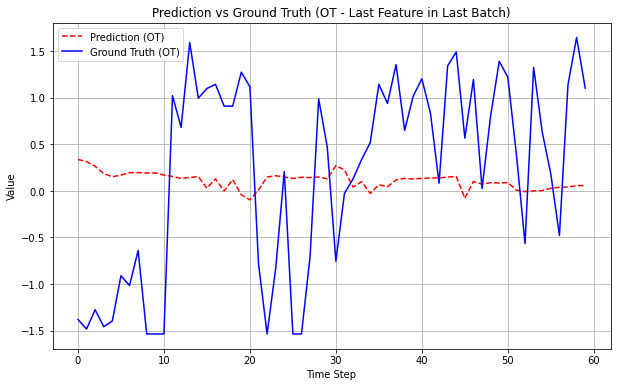

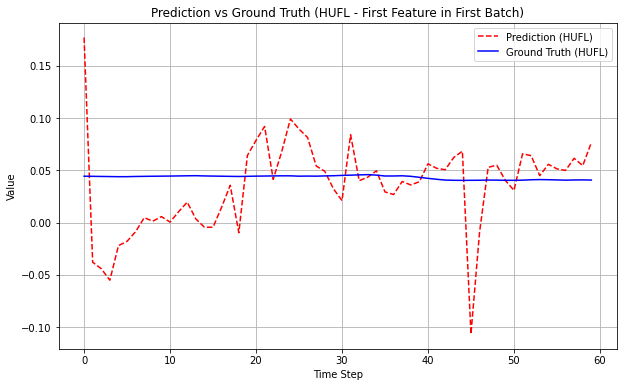

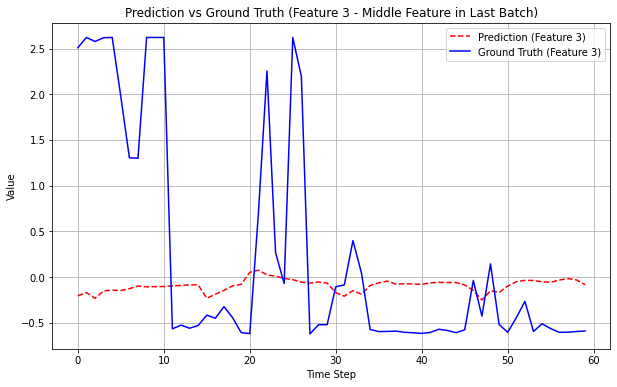

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Load prediction data
data_pred = np.load('/home/endtheme/Downloads/cos40007/Design Project/Autoformer/results/truck1_Informer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/real_prediction.npy')
data_pred = torch.from_numpy(data_pred).permute(0, 2, 1)

# Load ground truth data
data_gt = np.load('/home/endtheme/Downloads/cos40007/Design Project/Autoformer/results/truck1_Informer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
data_gt = torch.from_numpy(data_gt).permute(0, 2, 1)

# Check the shapes
print(f"Prediction shape: {data_pred.shape}")
print(f"Ground Truth shape: {data_gt.shape}")

# Plot 1: OT (Last feature in the last batch)
plt.figure(figsize=(10, 6))
plt.plot(data_pred[-1, -1, :].numpy(), label='Prediction (OT)', linestyle='--', color='red')
plt.plot(data_gt[-1, -1, :].numpy(), label='Ground Truth (OT)', linestyle='-', color='blue')
plt.title("Prediction vs Ground Truth (OT - Last Feature in Last Batch)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Plot 2: HUFL (First feature in the first batch)
plt.figure(figsize=(10, 6))
plt.plot(data_pred[0, 0, :].numpy(), label='Prediction (HUFL)', linestyle='--', color='red')
plt.plot(data_gt[0, 0, :].numpy(), label='Ground Truth (HUFL)', linestyle='-', color='blue')
plt.title("Prediction vs Ground Truth (HUFL - First Feature in First Batch)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Another feature (e.g., middle feature in last batch)
plt.figure(figsize=(10, 6))
plt.plot(data_pred[-1, 3, :].numpy(), label='Prediction (Feature 3)', linestyle='--', color='red')
plt.plot(data_gt[-1, 3, :].numpy(), label='Ground Truth (Feature 3)', linestyle='-', color='blue')
plt.title("Prediction vs Ground Truth (Feature 3 - Middle Feature in Last Batch)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
to_be_ploted = pd.read_csv('/home/endtheme/Downloads/cos40007/Design Project/MambaBitrate-RX3-1.csv', header=None)
to_be_ploted

,0,1
0,6.933931,6.975833
1,26.359436,26.818333
2,26.424380,26.890000
3,24.511276,24.926666
4,13.971659,14.188500
...,...,...
2506,23.814089,24.155000
2507,28.465176,28.875000
2508,27.392610,27.781666
2509,29.524204,29.975000


In [ ]:
to_be_ploted.iloc[:60, 0]

0      6.933931
1     26.359436
2     26.424380
3     24.511276
4     13.971659
5      7.719758
6      7.122119
7     11.888531
8     22.139225
9     13.978905
10     9.242942
11     9.247230
12     0.001082
13     0.000580
14     0.000360
15     0.043421
16    19.615830
17    23.734509
18     1.706540
19    21.236141
20    16.408712
21    39.726994
22    32.325653
23    16.434353
24     0.145392
25     0.000580
26     0.000580
27     0.000360
28    10.927138
29     8.893268
30     7.693552
31    10.718099
32    13.803310
33    26.371620
34    21.891033
35    24.105188
36    17.448927
37     3.620139
38     5.302406
39     5.052358
40     0.000580
41     0.000580
42     0.254368
43     4.070372
44    13.686017
45     1.132732
46     0.106330
47     8.241726
48    10.711783
49     8.632292
50    12.682390
51    22.810362
52    18.975359
53    14.738865
54    11.277616
55     7.447093
56    14.071692
57    22.528852
58    18.093287
59    20.948208
Name: 0, dtype: float64

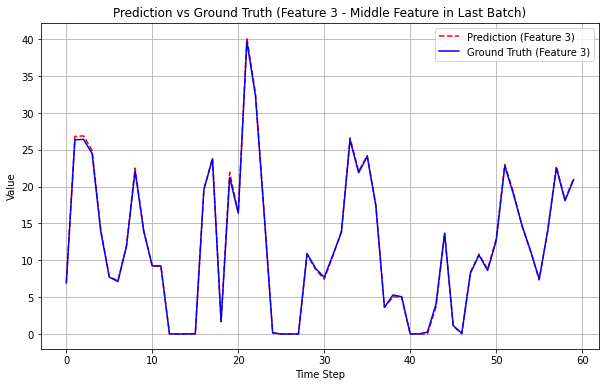

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(to_be_ploted.iloc[:60,1], label='Prediction (Feature 3)', linestyle='--', color='red')
plt.plot(to_be_ploted.iloc[:60,0], label='Ground Truth (Feature 3)', linestyle='-', color='blue')
plt.title("Prediction vs Ground Truth (Feature 3 - Middle Feature in Last Batch)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [5]:
from models.Autoformer import Model
import argparse
import os
import torch
from exp.exp_main import Exp_Main#exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict


parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')#模型id
parser.add_argument('--model', type=str, required=True, default='Autoformer',#选择模型
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')#数据类型
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')#数据文件夹路径
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')#具体文件
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')#不太懂 OT好像代表Output Target,要预测的单变量
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')#保存模型

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')#输入序列长度
parser.add_argument('--label_len', type=int, default=48, help='start token length')#这个label_len未完全搞懂
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#输出序列长度

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding不太能get到
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type2', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = ['Bitrate']
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = '/home/endtheme/Downloads/cos40007/Design Project/'
args.data_path ='truck1-1.csv' 
args.model_id='truck1-1'
args.model = 'Autoformer'
args.data = '5G'
args.features = 'M'
args.seq_len = 120
args.label_len = 60
args.pred_len = 60
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 1
args.enc_in = 10
args.dec_in =10
args.c_out = 10
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 32 
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10

model = Model(args)
model.load_state_dict(torch.load('/home/endtheme/Downloads/cos40007/Design Project/Autoformer/checkpoints/truck1_Autoformer_5G_ftM_sl120_ll60_pl60_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'))

<All keys matched successfully>